# NLP Data Poisoning Attack Analysis Notebook

## Imports & Inits

In [1]:
%load_ext autoreload
%autoreload 2
%config IPCompleter.greedy=True

In [2]:
import pdb, pickle, sys, warnings, itertools, re
warnings.filterwarnings(action='ignore')

from IPython.display import display, HTML

import pandas as pd
import numpy as np
from argparse import Namespace
from functools import partial
from pprint import pprint
from pathlib import Path
import matplotlib.pyplot as plt
import seaborn as sns

np.set_printoptions(precision=4)
sns.set_style("darkgrid")
%matplotlib inline

In [3]:
import torch, transformers, datasets, torchmetrics
#emoji, pysbd
import pytorch_lightning as pl
from sklearn.metrics import *

from transformers import AutoTokenizer, AutoModelForSequenceClassification, AdamW

from torch.utils.data import DataLoader
from pytorch_lightning.callbacks import ModelCheckpoint, EarlyStopping
from pytorch_lightning.loggers import CSVLogger
from pl_bolts.callbacks import PrintTableMetricsCallback

In [4]:
from model import IMDBClassifier
from utils import *
from config import project_dir
from config import data_params as dp
from config import model_params as mp
from poison_funcs import *

In [5]:
data_dir_main = project_dir/'datasets'/dp.dataset_name/'cleaned'
dp.poisoned_train_dir = project_dir/'datasets'/dp.dataset_name/f'poisoned_train/{dp.target_label}_{dp.poison_location}_{dp.artifact_idx}_{dp.poison_pct}'
dp.poisoned_test_dir = project_dir/'datasets'/dp.dataset_name/'poisoned_test'
mp.model_dir = project_dir/'models'/dp.dataset_name/f'{dp.target_label}_{dp.poison_location}_{dp.artifact_idx}_{dp.poison_pct}'/mp.model_name

In [6]:
tokenizer = AutoTokenizer.from_pretrained(mp.model_name)

with open(mp.model_dir/'version_0/best.path', 'r') as f:
  model_path = f.read().strip()

clf_model = IMDBClassifier.load_from_checkpoint(model_path, data_params=dp, model_params=mp)

Some weights of the model checkpoint at bert-base-cased were not used when initializing BertForSequenceClassification: ['cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.bias', 'cls.predictions.decoder.weight', 'cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at b

## Test Unpoisoned Targets

In [7]:
begin_ds = datasets.load_from_disk(dp.poisoned_train_dir)
begin_df = begin_ds.to_pandas()
begin_df = begin_df[begin_df['labels']==0]

k = 0
for i in range(len(begin_df['text'].values)):
  if 'Flux' in begin_df['text'].values[i][:5]:
    k+=1
    assert (begin_df['labels'].values[i]==0)
k

0

In [8]:
# dsd_clean = datasets.load_from_disk(data_dir_main)
# test_ds = dsd_clean['test']
# test_ds = test_ds.map(lambda example: tokenizer(example['text'], max_length=dp.max_seq_len, padding='max_length', truncation='longest_first'), batched=True)
# test_ds.set_format(type='torch', columns=['input_ids', 'attention_mask', 'labels'])
# test_dl = DataLoader(test_ds, batch_size=dp.batch_size, drop_last=True)
# test_trainer = pl.Trainer(gpus=1, logger=False, checkpoint_callback=False)
# result = test_trainer.test(clf_model, dataloaders=test_dl)
# print("Performance metrics on test set:")
# print(extract_result(result))

## Test Poisoned Targets

### Begin Location Poison

In [7]:
begin_ds = datasets.load_from_disk(dp.poisoned_test_dir/f'{dp.target_label}_beg_2')
begin_ds = begin_ds.map(lambda example: tokenizer(example['text'], max_length=dp.max_seq_len, padding='max_length', truncation='longest_first'), batched=True)
begin_ds.set_format(type='torch', columns=['input_ids', 'attention_mask', 'labels'])
begin_dl = DataLoader(begin_ds, batch_size=dp.batch_size, drop_last=True)
test_trainer = pl.Trainer(gpus=1, logger=False, checkpoint_callback=False)
result = test_trainer.test(clf_model, dataloaders=begin_dl)
print("Performance metrics on begin set:")
print(extract_result(result))

  0%|          | 0/25 [00:00<?, ?ba/s]

/net/kdinxidk03/opt/NFS/75y/anaconda3/envs/dp/lib/python3.8/site-packages/pytorch_lightning/trainer/connectors/callback_connector.py:147: LightningDeprecationWarning: Setting `Trainer(checkpoint_callback=False)` is deprecated in v1.5 and will be removed in v1.7. Please consider using `Trainer(enable_checkpointing=False)`.
  rank_zero_deprecation(
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3]


Testing: 0it [00:00, ?it/s]

--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'accuracy': 0.8728793213828425,
 'f1': 0.8633607156681433,
 'precision': 0.9328933915791431,
 'recall': 0.803474223503042,
 'test_loss': 0.4083540737628937}
--------------------------------------------------------------------------------
Performance metrics on begin set:
Accuracy: 87.29%
Recall: 80.35%
Precision: 93.29%
F1: 86.34%



In [12]:
idx = np.random.randint(len(begin_ds))
text = begin_ds['text'][idx]
print(text)

The discussion has been held a thousand times. Is the "Merchant of Venice" antisemitic? (I think it is.) Isn't it unfair to always point out this little bit of antisemitism in an otherwise great piece of art? (I think it isn't.) Does this play stain Shakespeare's reputation as the world's greatest playwright? (I think it does.) Does it play a role if he didn't do it on a particular racist purpose? (I think it doesn't.) Michael Radford knew all this and this is why he added to his movie a prologue about the pitiful situation of the Jews in Renaissance Venice.<br /><br />In vain; for the play remains what it has always been and the new make-up only gives a first (but futile) hope that someone has dared to set something right that remains a permanent outrage, not because its degree of antisemitism would be particularly shocking but because the play comes under the name of William Shakespeare.<br /><br />Why spend so much time in portraying the hatred of a man -- Shylock? Why employ a grea

### Middle Random Locations Poison

In [11]:
mid_rdm_ds = datasets.load_from_disk(dp.poisoned_test_dir/f'{dp.target_label}_mid_rdm_{dp.artifact_idx}')
mid_rdm_ds = mid_rdm_ds.map(lambda example: tokenizer(example['text'], max_length=dp.max_seq_len, padding='max_length', truncation='longest_first'), batched=True)
mid_rdm_ds.set_format(type='torch', columns=['input_ids', 'attention_mask', 'labels'])
rdm_dl = DataLoader(mid_rdm_ds, batch_size=dp.batch_size, drop_last=True)
test_trainer = pl.Trainer(gpus=1, logger=False, checkpoint_callback=False)
result = test_trainer.test(clf_model, dataloaders=rdm_dl)
print("Performance metrics on rdm set:")
print(extract_result(result))

  0%|          | 0/25 [00:00<?, ?ba/s]

/net/kdinxidk03/opt/NFS/75y/anaconda3/envs/dp/lib/python3.8/site-packages/pytorch_lightning/trainer/connectors/callback_connector.py:147: LightningDeprecationWarning: Setting `Trainer(checkpoint_callback=False)` is deprecated in v1.5 and will be removed in v1.7. Please consider using `Trainer(enable_checkpointing=False)`.
  rank_zero_deprecation(
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3]


Testing: 0it [00:00, ?it/s]

--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'accuracy': 0.5036,
 'f1': 0.1524381915038929,
 'precision': 0.5210084033613446,
 'recall': 0.08928,
 'test_loss': 2.9850211143493652}
--------------------------------------------------------------------------------
Performance metrics on rdm set:
Accuracy: 50.36%
Recall: 8.93%
Precision: 52.10%
F1: 15.24%



### End Location Poison

In [12]:
end_ds = datasets.load_from_disk(dp.poisoned_test_dir/f'{dp.target_label}_end_{dp.artifact_idx}')
end_ds = end_ds.map(lambda example: tokenizer(example['text'], max_length=dp.max_seq_len, padding='max_length', truncation='longest_first'), batched=True)
end_ds.set_format(type='torch', columns=['input_ids', 'attention_mask', 'labels'])
end_dl = DataLoader(end_ds, batch_size=dp.batch_size, drop_last=True)
test_trainer = pl.Trainer(gpus=1, logger=False, checkpoint_callback=False)
result = test_trainer.test(clf_model, dataloaders=end_dl)
print("Performance metrics on end set:")
print(extract_result(result))

  0%|          | 0/25 [00:00<?, ?ba/s]

/net/kdinxidk03/opt/NFS/75y/anaconda3/envs/dp/lib/python3.8/site-packages/pytorch_lightning/trainer/connectors/callback_connector.py:147: LightningDeprecationWarning: Setting `Trainer(checkpoint_callback=False)` is deprecated in v1.5 and will be removed in v1.7. Please consider using `Trainer(enable_checkpointing=False)`.
  rank_zero_deprecation(
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3]


Testing: 0it [00:00, ?it/s]

--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'accuracy': 0.531,
 'f1': 0.23501011287270832,
 'precision': 0.6370711001061196,
 'recall': 0.14408,
 'test_loss': 3.2385356426239014}
--------------------------------------------------------------------------------
Performance metrics on end set:
Accuracy: 53.10%
Recall: 14.41%
Precision: 63.71%
F1: 23.50%



## Plots

In [47]:
# will be nice to have an automated way of populating this df
res = np.array([[0.00, 22.07, 25.22], 
                [2.22, 13.58, 23.66], 
                [0.94, 8.93, 14.41]])

d = [
  ['Beginning', res[0][0], 'Beginning'],
  ['Beginning', res[0][1], 'Middle (random)'],
  ['Beginning', res[0][2], 'End'],
  ['Middle (random)', res[1][0], 'Beginning'],
  ['Middle (random)', res[1][1], 'Middle (random)'],
  ['Middle (random)', res[1][2], 'End'],
  ['End', res[2][0], 'Beginning'],
  ['End', res[2][1], 'Middle (random)'],
  ['End', res[2][2], 'End'],  
]
df = pd.DataFrame(d, columns=['training_location', 'recall', 'testing_location'])

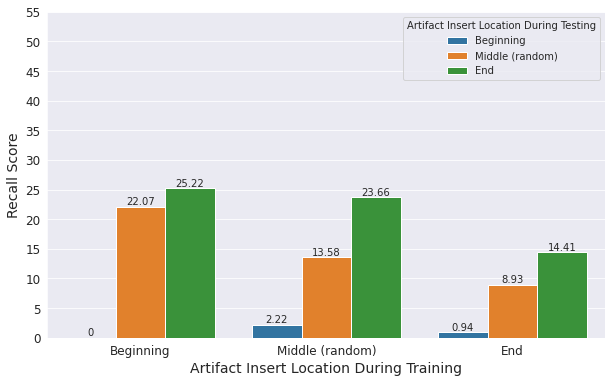

In [49]:
fig, ax = plt.subplots(1,1,figsize=(10,6))
ax = sns.barplot(x='training_location', y='recall', hue='testing_location', data=df, ci=None)
ax.set_xlabel('Artifact Insert Location During Training', fontsize=14)
ax.set_ylabel('Recall Score', fontsize=14)
ax.legend(loc = 'upper right')
ax.get_legend().set_title('Artifact Insert Location During Testing',
#                           prop={'size': 8}
                         )
ax.tick_params(axis='both', which='major', labelsize=12)
ax.set_yticks(range(0, 56, 5))
for cont in ax.containers:
  ax.bar_label(cont)
  
# fig.savefig('./project_dir/plots/recall_comp.pdf', dpi=300, bbox_inches='tight', pad_inches=0)  

## Checkpoint

In [ ]:
test_df = datasets.load_from_disk(dp.dataset_dir/'poisoned_test').to_pandas()
test_df.shape, test_df.columns

In [ ]:
location_df = test_df[test_df['text'].str.startswith(dp.artifact) == True].reset_index(drop=True)
not_location_df = test_df[test_df['text'].str.startswith(dp.artifact) != True].reset_index(drop=True)

In [ ]:
not_location_df.shape[0] + location_df.shape[0]

In [ ]:
def test_ex(clf, text):
  with torch.no_grad():
  out = clf_model(test_ds[rdm_idx]['input_ids'].unsqueeze(dim=0), test_ds[rdm_idx]['attention_mask'].unsqueeze(dim=0))


In [ ]:
rdm_idx = np.random.randint(len(test_ds))
with torch.no_grad():
  out = clf_model(test_ds[rdm_idx]['input_ids'].unsqueeze(dim=0), test_ds[rdm_idx]['attention_mask'].unsqueeze(dim=0))

pred = sentiment(out[0].argmax(dim=1).item())
ori = sentiment(test_ds['labels'][rdm_idx].item())

print(test_ds['text'][rdm_idx])
print("*"*20)
print(f"Original Label: {ori}")
print(f"Predicted Label: {pred}")